In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
#reload modules
%load_ext autoreload
%autoreload 2

In [3]:
import join_data as jd

In [4]:
from helpers import *

In [5]:
# filesavelabel = 'publicdatacategory_'
# predicted_delays_filename = './data_est_report_delays/category_borough_interaction_model_delays.csv'

filesavelabel = 'publicdatarisk_'
predicted_delays_filename = './data_est_report_delays/risk_borough_interaction_model_delays.csv'

# Load and join the public data

In [6]:
mergeddfpublic = jd.pipeline(directory = '../data/', FSfilename = 'FSR_221022.csv', FIfilename = 'FI_221022.csv', FWOfilename = 'FWO_221022.csv', FRAfilename = 'FRA_221024.csv')

In [7]:
mergeddfpublic.columns

Index(['OBJECTID', 'SRCategory', 'SRType', 'SRPriority', 'SRSource',
       'SRStatus', 'SRResolution', 'Borough', 'CommunityBoard',
       'ServiceRequestParentGlobalID', 'GlobalID', 'InitiatedDate',
       'SRClosedDate', 'SRCreatedDate', 'SRUpdatedDate', 'Descriptor1',
       'ComplaintType', 'CallerZipCode', 'SRCallerType', 'Latitude',
       'Longitude', 'Census Tract', 'NTA', 'SRGlobalID', 'InspectionType',
       'InspectionStatus', 'InspectionTPCondition', 'InspectionTPStructure',
       'TreePointDBH', 'InsGlobalID', 'InspectionDate', 'InsClosedDate',
       'InsCreatedDate', 'InsUpdatedDate', 'ParentInspectionGlobalID',
       'ReinspectionDate', 'Location', 'WOType', 'WOStatus', 'WOPriority',
       'CancelReason', 'WOCategory', 'WOGlobalID', 'WOClosedDate',
       'CancelDate', 'WOCreatedDate', 'WOUpdatedDate', 'WOEntity',
       'PROJSTARTDATE', 'WOProject', 'RecommendedSpecies', 'Location_WO',
       'RADefect', 'RADefectLocation', 'Failure', 'ImpactTarget',
       'Conse

### Load + join model estimates for reporting delays

We have a dataframe where we have predicted report delays for many incidents (that were used to train the model). We also want to have predicted reporting delays for other incidents. So what we will do is extract coefficients from that dataframe (we can do this perfectly except for Bayesian noise) and apply the model to all the incidents.

In [8]:
predicted_report_delays = pd.read_csv(predicted_delays_filename)
predicted_report_delays = predicted_report_delays.rename(columns = {'SRID': 'OBJECTID', 'delay': 'reporting_delay'})

In [9]:
predicted_report_delays.head()

,OBJECTID,Borough,CommunityBoard,Category,type,SRCreatedDate,SRClosedDate,death_time,TruncDuration,Duration,reporting_delay
0,17944200,Brooklyn,318.0,Hazard,Limb Down - Sidewalk,2020-06-30 03:03:00,2020-07-08 00:40:00,2020-06-30 15:20:00,0.511806,0.511806,11.34330
1,12185633,Staten Island,502.0,Remove Tree,Dead Tree Older Than 2 Years,2018-08-15 23:42:00,2019-04-02 02:24:43,2018-08-21 11:33:50,5.494329,5.494329,16.52310
2,13020663,Queens,408.0,Remove Tree,Poor Condition Cracked,2018-11-01 15:45:00,2018-11-05 10:58:19,2018-11-05 10:57:52,3.800602,3.800602,48.06360
3,12105835,Queens,410.0,Hazard,Limb Down - Other,2018-07-28 01:51:00,2018-08-01 18:21:00,2018-07-28 09:44:42,0.328958,0.328958,5.43021
4,11573966,Queens,403.0,Root/Sewer/Sidewalk,Sidewalk Consultation,2018-06-01 17:51:00,2018-06-29 14:30:00,2018-06-28 04:00:00,26.422917,26.422917,74.27160


In [10]:
predicted_report_delays_joinedwithfeatures = pd.merge(predicted_report_delays, mergeddfpublic, on='OBJECTID', how='left', suffixes=('', '_public')).drop_duplicates(subset = 'OBJECTID')

In [11]:
predicted_report_delays.count()

OBJECTID           80981
Borough            80981
CommunityBoard     80981
Category           80981
type               80981
SRCreatedDate      80981
SRClosedDate       79155
death_time         80981
TruncDuration      80981
Duration           80981
reporting_delay    80981
dtype: int64

In [12]:
predicted_report_delays_joinedwithfeatures.count()

OBJECTID               80981
Borough                80981
CommunityBoard         80981
Category               80981
type                   80981
                       ...  
WorkOrderGlobalID      20475
IncidentGlobalID       80981
inspection_attached    80981
wo_attached            80981
Risk_coded             80981
Length: 76, dtype: int64

In [13]:
#statsmodels from formula import
import statsmodels.formula.api as smf

In [14]:
predicted_report_delays_joinedwithfeatures.columns

Index(['OBJECTID', 'Borough', 'CommunityBoard', 'Category', 'type',
       'SRCreatedDate', 'SRClosedDate', 'death_time', 'TruncDuration',
       'Duration', 'reporting_delay', 'SRCategory', 'SRType', 'SRPriority',
       'SRSource', 'SRStatus', 'SRResolution', 'Borough_public',
       'CommunityBoard_public', 'ServiceRequestParentGlobalID', 'GlobalID',
       'InitiatedDate', 'SRClosedDate_public', 'SRCreatedDate_public',
       'SRUpdatedDate', 'Descriptor1', 'ComplaintType', 'CallerZipCode',
       'SRCallerType', 'Latitude', 'Longitude', 'Census Tract', 'NTA',
       'SRGlobalID', 'InspectionType', 'InspectionStatus',
       'InspectionTPCondition', 'InspectionTPStructure', 'TreePointDBH',
       'InsGlobalID', 'InspectionDate', 'InsClosedDate', 'InsCreatedDate',
       'InsUpdatedDate', 'ParentInspectionGlobalID', 'ReinspectionDate',
       'Location', 'WOType', 'WOStatus', 'WOPriority', 'CancelReason',
       'WOCategory', 'WOGlobalID', 'WOClosedDate', 'CancelDate',
       'WOCre

In [15]:
cols = ['SRCategory', 'Borough', 'RiskRating', 'InspectionTPCondition', 'TreePointDBH']

predicted_report_delays_joinedwithfeatures.loc[:, 'reporting_rate'] = predicted_report_delays_joinedwithfeatures.eval('1/reporting_delay')

predicted_report_delays_joinedwithfeatures.loc[:, 'log_reporting_rate'] = predicted_report_delays_joinedwithfeatures.eval('log(1/reporting_delay)')


#regress reporting delay on category, borough, and risk
model = smf.ols(formula='log_reporting_rate ~ 1 + C(SRCategory) + C(Borough) + C(Risk_coded) + C(Borough):C(Risk_coded) + InspectionTPCondition + np.log(TreePointDBH + 1)', data=predicted_report_delays_joinedwithfeatures).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     log_reporting_rate   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                 3.795e+05
Date:                Wed, 07 Jun 2023   Prob (F-statistic):               0.00
Time:                        09:00:16   Log-Likelihood:                 77270.
No. Observations:               79893   AIC:                        -1.545e+05
Df Residuals:                   79854   BIC:                        -1.541e+05
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
========================================================================================================================
                                                           coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------
Intercept                                               -0.8329      0.010    -83.846      0.000      -0.852      -0.813
C(SRCategory)[T.Illegal Tree Damage]                    -1.2568      0.002   -822.193      0.000      -1.260      -1.254
C(SRCategory)[T.Prune]                                  -1.5352      0.001  -1367.126      0.000      -1.537      -1.533
C(SRCategory)[T.Remove Tree]                            -1.4245      0.001  -1562.678      0.000      -1.426      -1.423
C(SRCategory)[T.Root/Sewer/Sidewalk]                    -3.1666      0.001  -3145.440      0.000      -3.169      -3.165
C(Borough)[T.Brooklyn]                                  -0.3721      0.015    -24.485      0.000      -0.402      -0.342
C(Borough)[T.Manhattan]                                  0.6942      0.014     49.155      0.000       0.667       0.722
C(Borough)[T.Queens]                                    -0.5936      0.010    -60.214      0.000      -0.613      -0.574
C(Borough)[T.Staten Island]                              0.0478      0.014      3.373      0.001       0.020       0.076
C(Risk_coded)[T.B]                                      -0.2151      0.011    -19.933      0.000      -0.236      -0.194
C(Risk_coded)[T.C]                                      -1.0408      0.010   -101.984      0.000      -1.061      -1.021
C(Risk_coded)[T.D]                                      -0.9066      0.010    -93.484      0.000      -0.926      -0.888
C(Risk_coded)[T.E]                                      -2.3806      0.027    -87.253      0.000      -2.434      -2.327
C(Risk_coded)[T.Unknown]                                -0.6035      0.011    -56.578      0.000      -0.624      -0.583
InspectionTPCondition[T.Dead]                           -0.3348      0.003   -119.144      0.000      -0.340      -0.329
InspectionTPCondition[T.Excellent]                      -0.4152      0.004    -93.687      0.000      -0.424      -0.407
InspectionTPCondition[T.Fair]                           -0.1963      0.003    -71.760      0.000      -0.202      -0.191
InspectionTPCondition[T.Good]                           -0.4168      0.003   -154.268      0.000      -0.422      -0.411
InspectionTPCondition[T.Poor]                           -0.0081      0.003     -2.950      0.003      -0.014      -0.003
InspectionTPCondition[T.Unknown]                        -0.9466      0.053    -17.776      0.000      -1.051      -0.842
C(Borough)[T.Brooklyn]:C(Risk_coded)[T.B]                0.2621      0.017     15.539      0.000       0.229       0.295
C(Borough)[T.Manhattan]:C(Risk_coded)[T.B]              -0.5635      0.016    -34.413      0.000      -0.596      -0.531
C(Borough)[T.Queens]:C(Risk_coded)[T.B]                  0

In [16]:
#now apply the model to nodups_rightdate
predicted_report_delays_joinedwithfeatures['log_reporting_rate_predicted'] = model.predict(predicted_report_delays_joinedwithfeatures)
predicted_report_delays_joinedwithfeatures['reporting_delay_predicted'] = predicted_report_delays_joinedwithfeatures.eval('1/exp(log_reporting_rate_predicted)')

(0.0, 100.0)

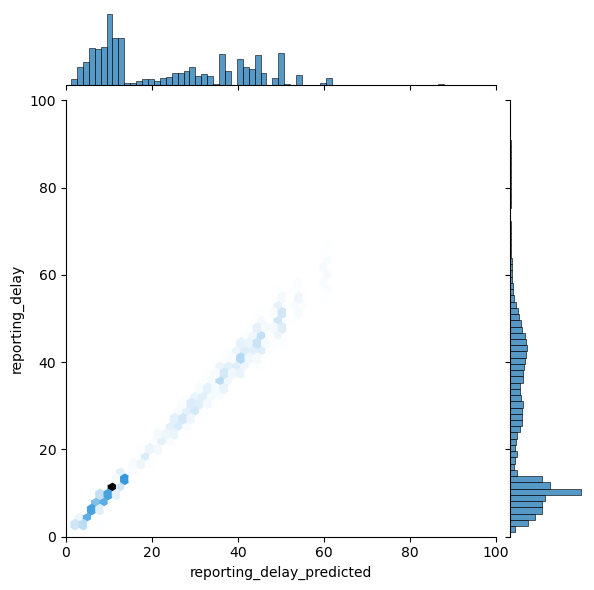

In [17]:
sns.jointplot(x='reporting_delay_predicted', y='reporting_delay', data=predicted_report_delays_joinedwithfeatures.query('reporting_delay_predicted < 100 and reporting_delay < 100'), kind='hex')
plt.xlim((0, 100))
plt.ylim((0, 100))

Ok, we have a good model of reporting delays, we can apply it to all the public data now

# Delay analysis final data preparation

First, combine multiple reports of the same incident so that I have one row per unique incident. Take first inspection and report date as the right date.

In [ ]:
wofinishdatecolumn = 'ActualFinishDate' # 'WOClosedDate'

In [18]:
nodups = mergeddfpublic[['IncidentGlobalID','SRCategory','SRCreatedDate', 'InspectionDate',wofinishdatecolumn,'Risk_coded','RiskRating','Borough','InspectionTPCondition', 'InspectionTPStructure',
       'TreePointDBH']].groupby('IncidentGlobalID').agg(
    {'SRCreatedDate': 'min', 'InspectionDate': 'min', wofinishdatecolumn: 'min', 'SRCategory': 'first', 'Risk_coded': 'first', 'Borough': 'first', 'RiskRating': 'first', 'InspectionTPCondition': 'first', 'InspectionTPStructure': 'first',
       'TreePointDBH': 'first'}).reset_index()
nodups['inspection_delay'] = (nodups['InspectionDate'] - nodups['SRCreatedDate']).dt.total_seconds() / 3600 /24
nodups['work_delay'] = (nodups[wofinishdatecolumn] - nodups['InspectionDate']).dt.total_seconds() / 3600 /24
nodups[['SRCreatedDate','InspectionDate', wofinishdatecolumn]].describe(datetime_is_numeric=True)

,SRCreatedDate,InspectionDate,WOClosedDate
count,552181,281992,144416
mean,2018-12-24 03:10:25.272691968,2019-01-24 20:10:01.489754624,2019-03-12 00:42:54.714547456
min,2015-02-28 14:03:49,1900-01-01 00:00:00,2015-03-03 05:00:00
25%,2017-04-07 19:40:00,2017-06-21 10:01:09.500000,2017-08-15 13:06:00
50%,2018-11-18 22:47:00,2018-12-21 09:41:59.500000,2019-03-25 18:24:00
75%,2020-08-18 21:17:00,2020-08-28 16:13:42.500000,2020-08-23 19:20:42.249999872
max,2022-09-01 02:05:31,2022-08-31 20:44:30,2022-08-31 21:41:07


In [19]:
nodups_rightdate = nodups[(nodups['SRCreatedDate'] >= '2017-06-30') & (nodups['SRCreatedDate'] < '2020-07-01')]

In [20]:
nodups_rightdate = nodups_rightdate[nodups_rightdate.SRCategory.isin(predicted_report_delays_joinedwithfeatures.SRCategory.unique())]

In [34]:
nodups_rightdate[['SRCreatedDate','InspectionDate', wofinishdatecolumn, 'work_delay']].describe(datetime_is_numeric=True)

,SRCreatedDate,InspectionDate,WOClosedDate,work_delay
count,106903,106903,52709,52709.000000
mean,2018-12-06 15:34:57.302395648,2019-01-01 20:01:25.912761856,2019-05-24 22:24:07.486918656,166.165843
min,2017-06-30 00:02:43,1900-01-01 00:00:00,2015-04-07 15:13:00,-1425.543519
25%,2018-04-02 14:49:30,2018-04-16 10:45:17.500000,2018-07-26 18:32:00,5.119306
50%,2018-10-30 00:10:00,2018-11-16 15:17:54,2019-04-16 19:20:00,43.104861
75%,2019-08-15 12:36:00,2019-09-12 11:48:24.500000,2020-02-20 16:58:00,205.237083
max,2020-06-30 23:46:32,2022-08-25 16:04:55,2022-08-31 18:07:00,2268.353472
std,NaN,NaN,NaN,273.609788


In [22]:
nodups_rightdate.loc[:,'log_reporting_rate'] = model.predict(nodups_rightdate)
nodups_rightdate.loc[:,'reporting_delay'] = nodups_rightdate.eval('1/exp(log_reporting_rate)')

In [23]:
nodups_rightdate.count()

IncidentGlobalID         169881
SRCreatedDate            169881
InspectionDate           109205
WOClosedDate              53222
SRCategory               169881
Risk_coded               169881
Borough                  169848
RiskRating               102559
InspectionTPCondition    108468
InspectionTPStructure    108466
TreePointDBH             106905
inspection_delay         109205
work_delay                53220
log_reporting_rate       106903
reporting_delay          106903
dtype: int64

In [24]:
nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].median()

/tmp/ipykernel_5694/2028202929.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  nodups_rightdate.groupby(['SRCategory', 'Borough'])['reporting_delay', 'inspection_delay', 'work_delay'].median()


reporting_delay  inspection_delay  \
SRCategory          Borough                                            
Hazard              Bronx                 7.024545          1.963947   
                    Brooklyn             10.477734          3.959722   
                    Manhattan             5.484593          0.485382   
                    Queens                8.693329          1.853906   
                    Staten Island         5.361944          1.502153   
Illegal Tree Damage Bronx                30.487858          8.880150   
                    Brooklyn             45.337224         37.128084   
                    Manhattan            24.072812          4.347917   
                    Queens               37.807152         25.789086   
                    Staten Island        18.848486          3.852153   
Prune               Bronx                40.522270         13.216713   
                    Brooklyn             48.721781         10.871279   
                    Manhattan            31.800551          5.618750   
                    Queens               50.126144          8.888241   
                    Staten Island        24.932162          3.250000   
Remove Tree         Bronx                33.265712          6.816672   
                    Brooklyn             43.513636         13.959201   
                    Manhattan            26.159408          3.440972   
                    Queens               37.933595          6.906262   
                    Staten Island        22.282820          4.486366   
Root/Sewer/Sidewalk Bronx               207.357271         18.884167   
                    Brooklyn            309.321297         20.887147   
                    Manhattan           162.645513         15.874965   
                    Queens              256.566166         18.859514   
                    Staten Island       158.553671         20.829329   

                                   work_delay  
SRCategory          Borough                    
Hazard              Bronx           19.923738  
                    Brooklyn        17.396655  
                    Manhattan        5.122257  
                    Queens           7.265150  
                    Staten Island   13.049502  
Illegal Tree Damage Bronx          178.062766  
                    Brooklyn       141.430556  
                    Manhattan       20.597569  
                    Queens          83.216366  
                    Staten Island  105.507639  
Prune               Bronx           77.428715  
                    Brooklyn       124.250451  
                    Manhattan      129.888414  
                    Queens          57.306134  
                    Staten Island   70.010943  
Remove Tree         Bronx          212.079444  
                    Brooklyn       144.244780  
                    Manhattan       78.592361  
                    Queens         125.363837  
                    Staten Island  164.623727  
Root/Sewer/Sidewalk Bronx          561.174635  
                    Brooklyn       653.202946  
                    Manhattan      275.303403  
                    Queens         663.898646  
                    Staten Island  764.016921

In [25]:
#only looking at the inspected set
nodups_rightdate = nodups_rightdate.dropna(subset = ['reporting_delay'])

In [26]:
addressed = nodups_rightdate.groupby(['SRCategory', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()
addressed

/tmp/ipykernel_5694/1414922349.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  addressed = nodups_rightdate.groupby(['SRCategory', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()


,SRCategory,Borough,inspection_delay,work_delay
0,Hazard,Bronx,1.0,0.577286
1,Hazard,Brooklyn,1.0,0.509462
2,Hazard,Manhattan,1.0,0.899793
3,Hazard,Queens,1.0,0.641441
4,Hazard,Staten Island,1.0,0.721577
5,Illegal Tree Damage,Bronx,1.0,0.227273
6,Illegal Tree Damage,Brooklyn,1.0,0.144084
7,Illegal Tree Damage,Manhattan,1.0,0.447903
8,Illegal Tree Damage,Queens,1.0,0.231572
9,Illegal Tree Damage,Staten Island,1.0,0.360153


In [27]:
addressed = nodups_rightdate.groupby(['Risk_coded', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()
addressed

/tmp/ipykernel_5694/4094152123.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  addressed = nodups_rightdate.groupby(['Risk_coded', 'Borough'])['inspection_delay', 'work_delay'].agg(lambda x: 1-np.mean(np.isnan(x))).reset_index()


,Risk_coded,Borough,inspection_delay,work_delay
0,A,Bronx,1.0,0.934132
1,A,Brooklyn,1.0,0.941606
2,A,Manhattan,1.0,0.986364
3,A,Queens,1.0,0.946251
4,A,Staten Island,1.0,0.970803
5,B,Bronx,1.0,0.891200
6,B,Brooklyn,1.0,0.892449
7,B,Manhattan,1.0,0.991209
8,B,Queens,1.0,0.918572
9,B,Staten Island,1.0,0.936123


In [28]:
# #turn inpsection and work delays into rows instead of columns
# addressed = addressed.melt(id_vars=['SRCategory', 'Borough'], value_vars=['inspection_delay', 'work_delay'], var_name='delay_type', value_name='percent_addressed')

In [29]:
# addressed = addressed.rename({'percent_addressed': 'Fraction addressed', 'delay_type': 'Action'}, axis=1)
# addressed.loc[:, 'Action'] = addressed.loc[:, 'Action'].str.replace('inspection_delay', 'Inspection').str.replace('work_delay', 'Work order')
# plot = sns.catplot(
#     data=addressed.query('SRCategory == "Hazard" and Action=="Work order"'), kind="bar",
#     x="Borough", y="Fraction addressed", hue="Action",
#     errorbar="sd", palette= ['green'], legend_out = False, #, alpha=.6, height=6
#     order = ['Manhattan', 'Queens', 'Staten Island', 'Bronx', 'Brooklyn']
# )
# legend = plot._legend
# legend.set_frame_on(False)
# plt.ylim(0, 1.1)
# plt.xlabel(None)
# plt.savefig(f'plots/{filesavelabel}hazard_fractionaddressed.pdf', bbox_inches='tight')

# Plotting

<!-- ## What fraction of incidents are actually addressed -->

## Delays conditional on addressed

In [30]:
# plot_bar_by_type(nodups_rightdate, typecol = 'SRCategory', othergroupby = 'Borough', impute_missing_work_order = False, label = f'{filesavelabel}')

In [31]:
nodups_rightdate = nodups_rightdate.sort_values(by = 'Risk_coded', ascending = True)

Overall split by typecol but not other group


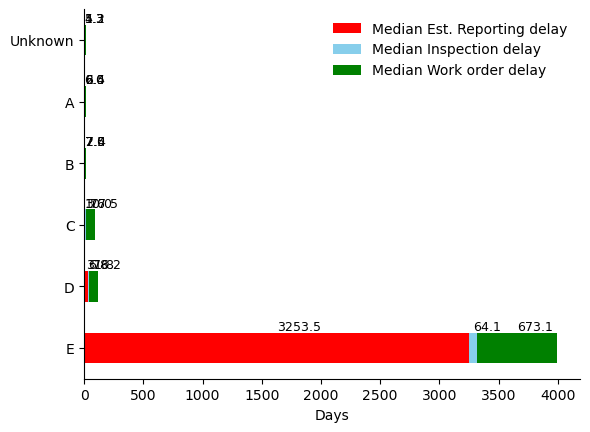

A


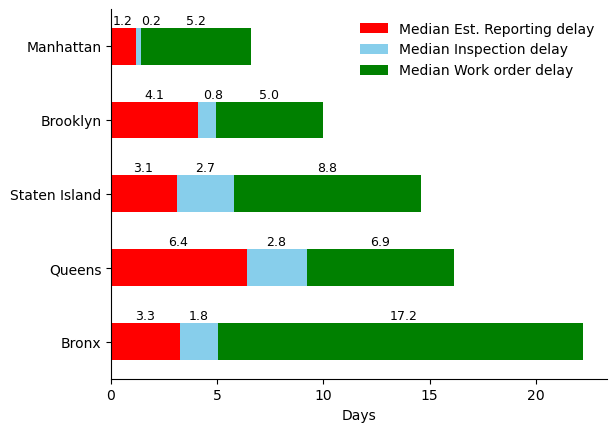

B


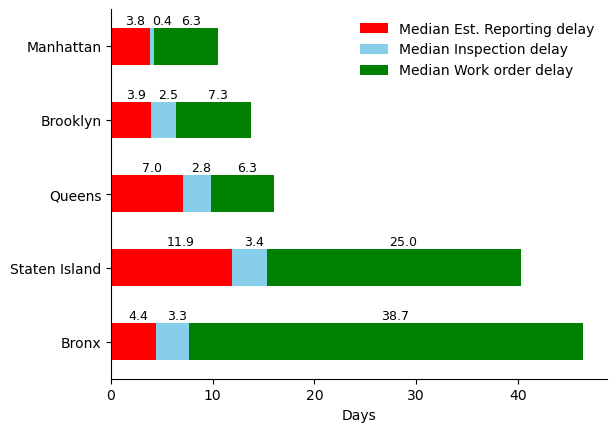

C


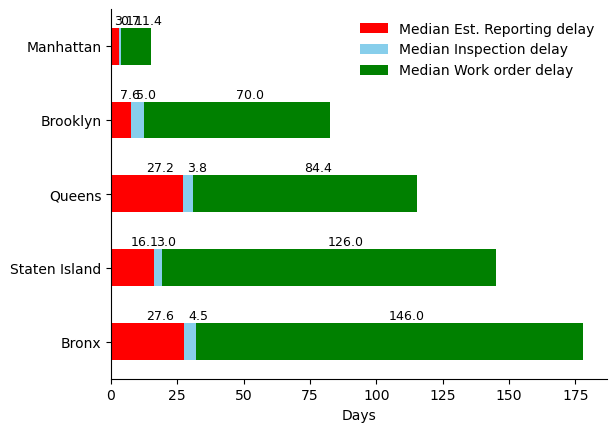

D


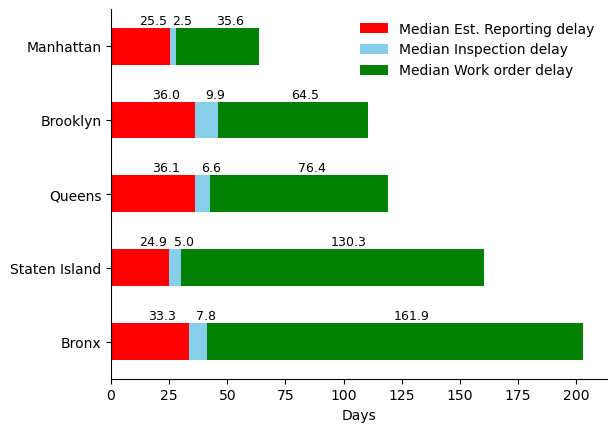

E


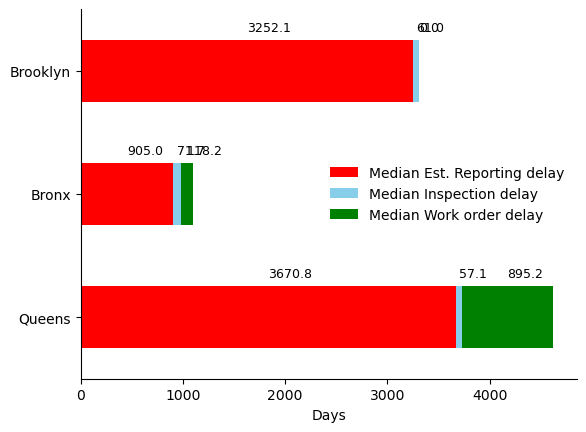

Unknown


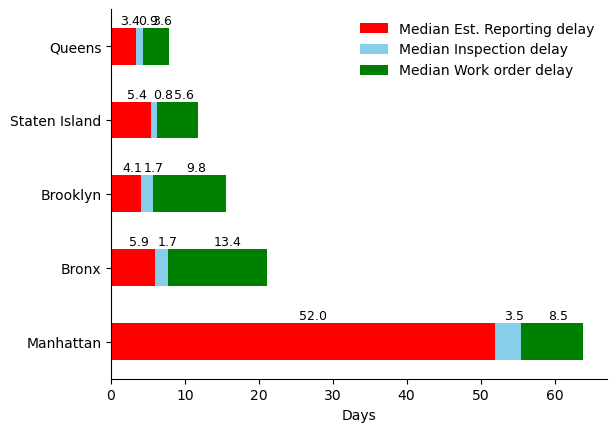

In [32]:
plot_bar_by_type(nodups_rightdate.dropna(subset = ['inspection_delay']), typecol = 'Risk_coded', othergroupby = 'Borough', impute_missing_work_order = False, label = f'{filesavelabel}risk_notimputed_')

Overall split by typecol but not other group


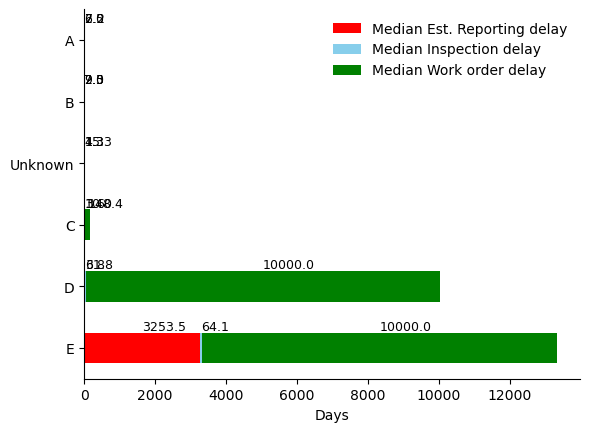

A


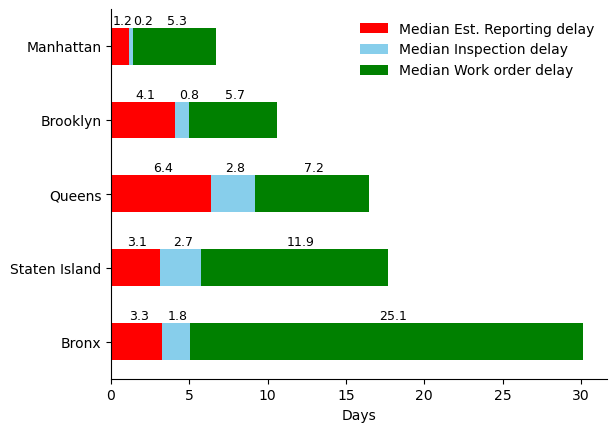

B


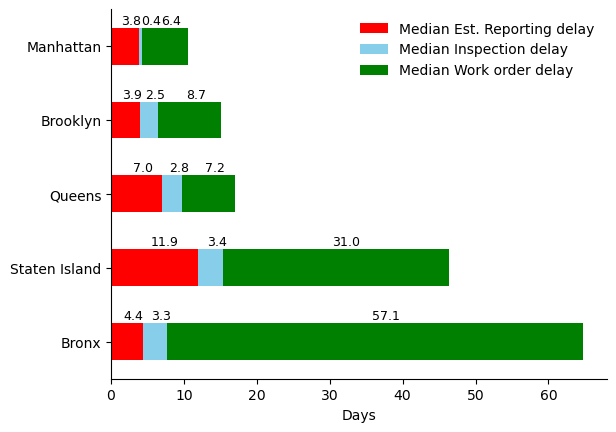

C


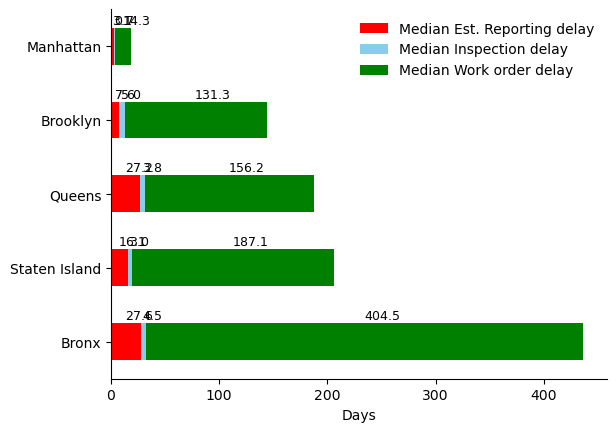

D


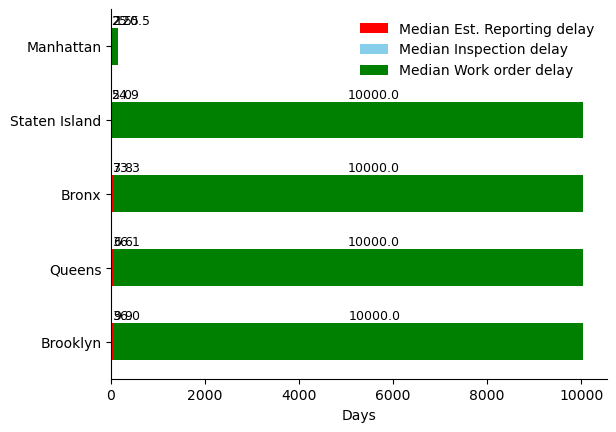

E


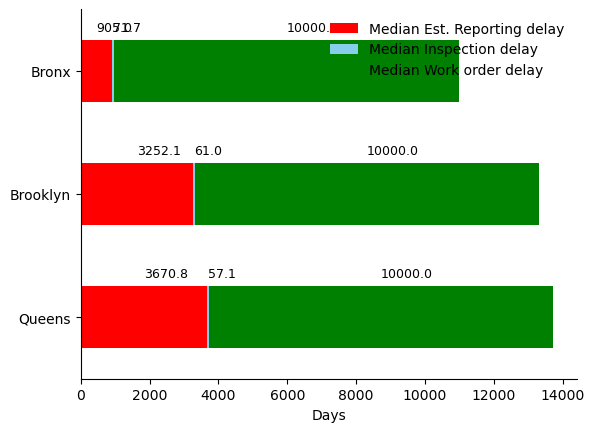

Unknown


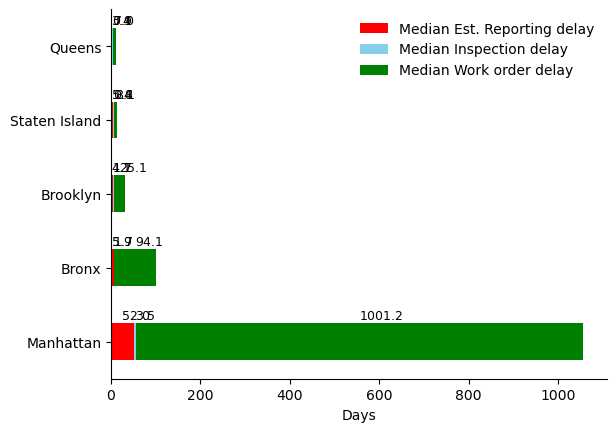

In [33]:
plot_bar_by_type(nodups_rightdate.dropna(subset = ['inspection_delay']), typecol = 'Risk_coded', othergroupby = 'Borough', impute_missing_work_order = True, label = f'{filesavelabel}risk_imputed_')